<a href="https://colab.research.google.com/github/cagatayeskin/Data-Fitting-with-ANNs/blob/main/Linear_Data_with_Errors_on_Both_Axes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Linear Data with Errors on Both Axes (Data with Normally Distributed Errors)***

## **General Solution**
We start with providing the general solution proposed by **York (1966)**. To test the general solution, we first create a test data. After moving on to the Artificial Neural Network part, we use this data set again to compare two methods.

We use a linear model in below form to create data points. After creating $N_{test}$ number of data points on the line given by model, we sample set of $\sigma_{x_i}$ and $\sigma_{y_i}$ for each point. Using variances, we sample noise values, $δx_i$ and $δy_i$ for each point from Gaussian distribution. This way we create a test data and use it as an example to show predictions of two methods. Accuracy of the methods will be subject to further testing later in this notebook.

$$
    y = b_{true}x + a_{true}
$$


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.8.0


## Create a test data and show it on a plot with York's general solution

In [ ]:
N_test = 50 # number of data points
sigma_X = np.random.uniform(0.03, 0.07, N_test) # sample x coordinate sigmas from uniform distribution
sigma_Y = np.random.uniform(0.05, 0.10, N_test) # sample y coordinate sigmas from uniform distribution
noise_X = np.multiply(sigma_X, np.random.randn(N_test)) # error on x data (normally distributed)
noise_Y = np.multiply(sigma_Y, np.random.randn(N_test)) # error on y data (normally distributed)
 
# True parameters of the model
a_true = 3.7
b_true = -1.5

X = np.linspace(0.1, 0.9, N_test) + noise_X # observed X points
Y = b_true*(X-noise_X) + a_true + noise_Y # observed Y points

### York's General solution

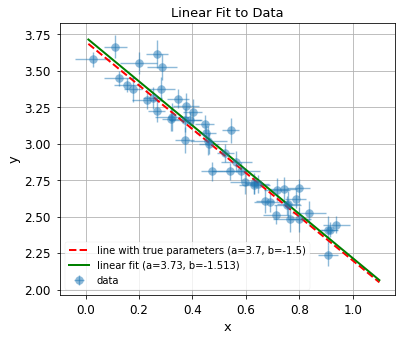

In [ ]:
# Create a figure
fig = plt.figure(figsize=(6, 5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data
#plt.plot(X, Y, 'o', label='data', ms=8.5, alpha=0.5)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=8.5, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
x_plot = np.linspace(0.01, 1.1, N_test)
y_true_plot = b_true*x_plot + a_true
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, color = 'red', label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ')'))


# Function that calculates the parameters (using same notation with York)
def linear_fit(b_pred, iter): # start with a prediction of b and number of iterations
    for k in range(iter): 
        w_X = 1/np.power(sigma_X, 2) 
        w_Y = 1/np.power(sigma_Y, 2)
        W = np.multiply(w_X, w_Y)/(b_pred**2*w_Y + w_X)
        X_bar = np.sum(np.multiply(W, X))/np.sum(W)
        Y_bar = np.sum(np.multiply(W, Y))/np.sum(W)
        U = X - X_bar
        V = Y - Y_bar
        alpha_numerator = 0
        alpha_denominator = 0
        beta_numerator = 0
        beta_denominator = 0
        gamma_numerator = 0
        gamma_denominator = 0
        for i in range(N_test):
            alpha_numerator = alpha_numerator + W[i]**2*U[i]*V[i]/w_X[i]
            alpha_denominator = alpha_denominator + W[i]**2*U[i]**2/w_X[i]
            beta_numerator = beta_numerator + (W[i]**2*V[i]**2/w_X[i]) - W[i]*U[i]**2
            beta_denominator = beta_denominator + W[i]**2*U[i]**2/w_X[i]
            gamma_numerator = gamma_numerator + W[i]*U[i]*V[i]
            gamma_denominator = gamma_denominator + W[i]**2*U[i]**2/w_X[i]
        alpha = (2*alpha_numerator)/(3*alpha_denominator)
        beta = beta_numerator/(3*beta_denominator)
        gamma = -gamma_numerator/gamma_denominator
        b = []        
        for j in range(3): # there are three roots to be found
            b.append(alpha + 2*np.sqrt(alpha**2 - beta) * 
                     np.cos(1/3*(np.arccos((alpha**3 - 3*alpha*beta/2 + gamma/2)/
                                           (alpha**2 - beta)**(3/2)) + 2*np.pi*j)))
        b_pred = b[2] # root we are looking for is generally the third one (if solution is unusual check that)
        
    a_pred = Y_bar - b_pred*X_bar # calculate the intercept
    return a_pred, b_pred

# Defining predicted parameters
a_fit, b_fit = linear_fit(5, 4) # input a reasonable b prediction (small values can cause error)

# Plotting linear fit
y_plot = a_fit + b_fit*x_plot
plt.plot(x_plot, y_plot, linewidth = 2.0, color = 'green', label=('linear fit (a=' + str(np.round(a_fit, 3)) + 
                                                 ', b=' + str(np.round(b_fit, 3)) + ')'))

# Plot specs
plt.tick_params(labelsize=12)
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.title('Linear Fit to Data', fontsize = 13)
plt.legend(fontsize = 10)
plt.grid()

# **Fitting a Model to Data using the Artificial Neural Network (ANN)**
In this part, we start by defining the ANN, then we provide weights of the pre-trained network so that there isn't a necessary training process. Training data generation is held the same way as we did in the first part of the notebook while producing a test data. But this time we create large number of different models from which we sample data with different number of points. We also provide training part. To supply the data to ANN, we first give it the appropriate shape, so before the testing we do the preprocessing part. After that, we continue further testing by using three different models. At the end, we find the parameter uncertainties and provide a metric to show accuracy of the ANN's predictions.

## Build the ANN for linear model define its architecture

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape = (None, 4)),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(2),
])

model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(0.001))

##Download the previously trained model weights

Training data was created from models with boundaries
$$
-5.0<a<5.0
$$
$$
-5.0<b<5.0
$$


In [ ]:
!wget https://drive.google.com/uc?id=1z7OWdC9vytB6TomXast_5Q9UoKsYqah6&export=download 
model.load_weights('uc?id=1z7OWdC9vytB6TomXast_5Q9UoKsYqah6')

--2022-03-27 14:37:24--  https://drive.google.com/uc?id=1z7OWdC9vytB6TomXast_5Q9UoKsYqah6
Resolving drive.google.com (drive.google.com)... 172.217.13.110, 2607:f8b0:400c:c03::65, 2607:f8b0:400c:c03::71, ...
Connecting to drive.google.com (drive.google.com)|172.217.13.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cjhf3a60i1os1l1gslir3bl7sm4srq4h/1648391775000/06440322669498725628/*/1z7OWdC9vytB6TomXast_5Q9UoKsYqah6 [following]
--2022-03-27 14:37:24--  https://doc-0k-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cjhf3a60i1os1l1gslir3bl7sm4srq4h/1648391775000/06440322669498725628/*/1z7OWdC9vytB6TomXast_5Q9UoKsYqah6
Resolving doc-0k-9s-docs.googleusercontent.com (doc-0k-9s-docs.googleusercontent.com)... 173.194.74.132, 2607:f8b0:4001:c0d::84
Connecting to doc-0k-9s-docs.googleusercontent.com (doc-0k-9s-docs.googleusercontent.com

##Training (if you downloaded the weights, you can skip this step)

### Create training and validation datasets

In [ ]:
J = 50000 # number of training models

a_train = np.linspace(-5.0, 5.0, J)
b_train = np.linspace(-5.0, 5.0, J)

# Shuffling the arrays to get random a and b pairs
np.random.shuffle(a_train)
np.random.shuffle(b_train)

def data_set(N, a, b):
  sigma_x = np.random.uniform(0.03, 0.07, N) # sample x coordinate sigmas from uniform distribution
  sigma_y = np.random.uniform(0.05, 0.10, N) # sample y coordinate sigmas from uniform distribution
  noise_x = np.multiply(sigma_x, np.random.randn(N)) # error on x data (normally distributed)
  noise_y = np.multiply(sigma_y, np.random.randn(N)) # error on y data (normally distributed) 
  x = np.linspace(0.1, 0.9, N) + noise_x
  y = a + b * (x-noise_x) + noise_y
  training_features = np.zeros((N, 4))
  for i in range(N):
    for k in range(1):
      training_features[i,k] = x[i]
      training_features[i,k+1] = y[i]
      training_features[i,k+2] = sigma_x[i]
      training_features[i,k+3] = sigma_y[i]
  return(training_features)

In [ ]:
training_data = []
training_labels = np.zeros((J,2))

for j in range(J):
  N = np.random.randint(10,100)
  training_data.append(data_set(N, a_train[j], b_train[j]))
  training_labels[j,0] = a_train[j]
  training_labels[j,1] = b_train[j]

In [ ]:
# Manually split dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.20)
train_features = tf.ragged.constant(train_features) # define them as ragged tensor
val_features = tf.ragged.constant(val_features)

### Training process

In [ ]:
%%time
history = model.fit(
    train_features, train_labels,
    validation_data = (val_features, val_labels),
    verbose=1, epochs=75)

Epoch 1/75
1250/1250 [==============================] - 69s 54ms/step - loss: 0.9513 - val_loss: 0.0702
Epoch 2/75
1250/1250 [==============================] - 66s 52ms/step - loss: 0.0342 - val_loss: 0.0195
Epoch 3/75
1250/1250 [==============================] - 63s 51ms/step - loss: 0.0182 - val_loss: 0.0128
Epoch 4/75
1250/1250 [==============================] - 66s 52ms/step - loss: 0.0138 - val_loss: 0.0095
Epoch 5/75
1250/1250 [==============================] - 66s 53ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 6/75
1250/1250 [==============================] - 67s 54ms/step - loss: 0.0096 - val_loss: 0.0117
Epoch 7/75
1250/1250 [==============================] - 65s 52ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 8/75
1250/1250 [==============================] - 64s 51ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 9/75
1250/1250 [==============================] - 63s 51ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 10/75
1250/1250 [==============================] - 64s 51m

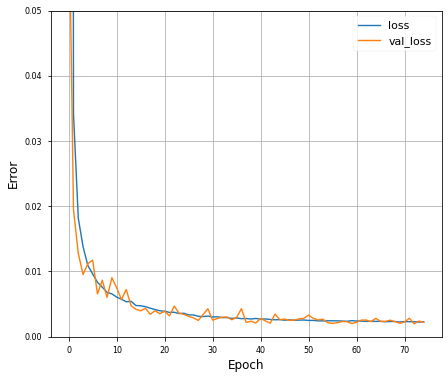

In [ ]:
def plot_loss(history):
    fig = plt.figure(figsize=(7, 6))
    plt.style.use('seaborn-paper')
    plt.rc('font', family='sans-serif')  
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.05])
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Error', fontsize = 12)
    plt.legend()
    plt.grid(True)
    plt.legend(fontsize = 11)
plot_loss(history)

## Make predictions on test data

### Show the summary of ANN layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


### Give appropriate shape to the test data that is created at the beginning of the notebook

In [ ]:
# Now give the appropriate shape for our test data which we created in the beginning of the notebook
main = np.zeros((1, N_test, 4))

for i in range(N_test):
    main[0,i,0] = X[i]
    main[0,i,1] = Y[i]
    main[0,i,2] = sigma_X[i]
    main[0,i,3] = sigma_Y[i]

### Plot test data, York's general solution and ANN's prediction on the same figure

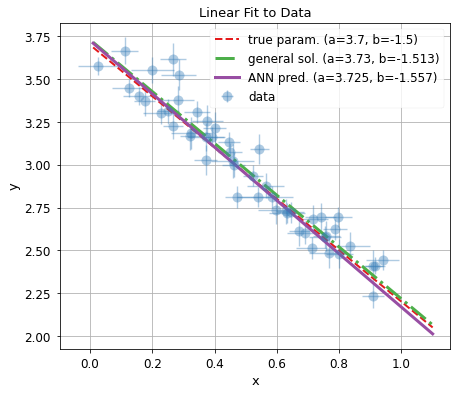

In [ ]:
# Create a figure
fig = plt.figure(figsize=(7, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=18.5, alpha=0.2)
plt.errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=10.0, alpha=0.4, color = '#377eb8') # error bars show SD

# Plotting the line with true parameters
plt.plot(x_plot, y_true_plot, '--', linewidth = 2, label=('true param. (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ')'), color = '#e41a1c')

# Plotting linear fit
plt.plot(x_plot, y_plot, '-.', linewidth = 3, label=('general sol. (a=' + str(np.round(a_fit, 3)) + 
                                                 ', b=' + str(np.round(b_fit, 3)) + ')'), color = '#4daf4a')

# Predicting
a_fit_DNN = model.predict(main)[0,0]
b_fit_DNN = model.predict(main)[0,1]

# Plotting predictions of DNN
y_DNN = a_fit_DNN + b_fit_DNN*x_plot
plt.plot(x_plot, y_DNN, linewidth = 3, label = ('ANN pred. (a=' + str(np.round(a_fit_DNN, 3)) +
                                                  ', b=' + str(np.round(b_fit_DNN, 3)) + ')'), color = '#984ea3')

# Plot specs
plt.tick_params(labelsize=12)
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.title('Linear Fit to Data', fontsize = 13)
plt.legend(fontsize = 12)
plt.grid()

## Now, create three different test data from different models and make predictions on them using trained ANNs. We also show predictions obtained by York's general solution.

In [ ]:
true_params = np.zeros([3,2])

# True parameters of the models
##First model
true_params[0,0] = 0.7
true_params[0,1] = -1.5

##Second model

true_params[1,0] = -3.1
true_params[1,1] = 0.8

##Third model

true_params[2,0] = 1.2
true_params[2,1] = 2.3

data_point_nums = [90,55,25] # number of data points

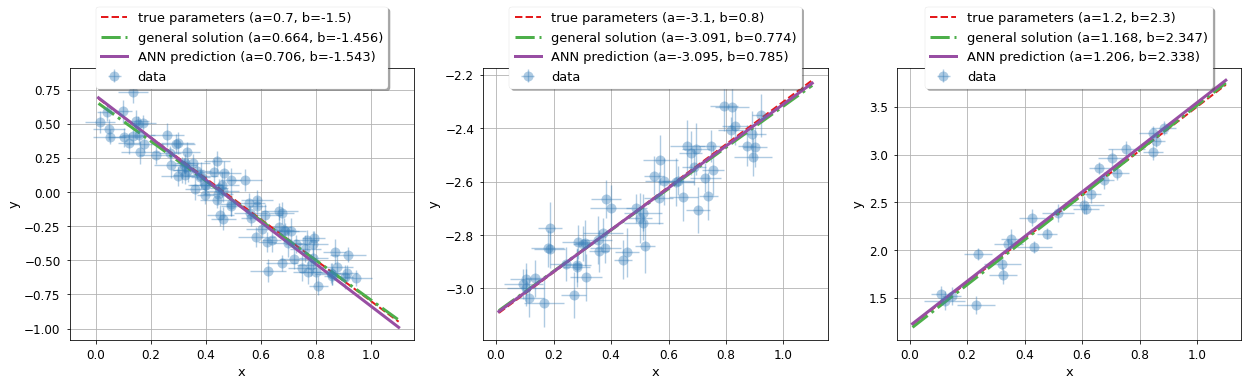

In [ ]:
#Below function creates data from a model and make prediction on data using trained ANN
def triple(a, b, num, N):
  sigma_X = np.random.uniform(0.03, 0.07, N) # sample x coordinate sigmas from uniform distribution
  sigma_Y = np.random.uniform(0.05, 0.10, N) # sample y coordinate sigmas from uniform distribution
  noise_X = np.multiply(sigma_X, np.random.randn(N)) # error on x data (normally distributed)
  noise_Y = np.multiply(sigma_Y, np.random.randn(N)) # error on y data (normally distributed)
  X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
  Y = b*(X-noise_X) + a + noise_Y # observed Y points

  def linear_fit(b_pred, iter): # start with a prediction of b and number of iterations
    for k in range(iter): 
        w_X = 1/np.power(sigma_X, 2) 
        w_Y = 1/np.power(sigma_Y, 2) 
        W = np.multiply(w_X, w_Y)/(b_pred**2*w_Y + w_X)
        X_bar = np.sum(np.multiply(W, X))/np.sum(W)
        Y_bar = np.sum(np.multiply(W, Y))/np.sum(W)
        U = X - X_bar
        V = Y - Y_bar
        alpha_numerator = 0
        alpha_denominator = 0
        beta_numerator = 0
        beta_denominator = 0
        gamma_numerator = 0
        gamma_denominator = 0
        for i in range(N):
            alpha_numerator = alpha_numerator + W[i]**2*U[i]*V[i]/w_X[i]
            alpha_denominator = alpha_denominator + W[i]**2*U[i]**2/w_X[i]
            beta_numerator = beta_numerator + (W[i]**2*V[i]**2/w_X[i]) - W[i]*U[i]**2
            beta_denominator = beta_denominator + W[i]**2*U[i]**2/w_X[i]
            gamma_numerator = gamma_numerator + W[i]*U[i]*V[i]
            gamma_denominator = gamma_denominator + W[i]**2*U[i]**2/w_X[i]
        alpha = (2*alpha_numerator)/(3*alpha_denominator)
        beta = beta_numerator/(3*beta_denominator)
        gamma = -gamma_numerator/gamma_denominator
        b = []        
        for j in range(3): # there are three roots to be found
            b.append(alpha + 2*np.sqrt(alpha**2 - beta) * 
                     np.cos(1/3*(np.arccos((alpha**3 - 3*alpha*beta/2 + gamma/2)/
                                           (alpha**2 - beta)**(3/2)) + 2*np.pi*j)))
        b_pred = b[2] # root we are looking for is generally the third one (if solution is unusual check that)
        
    a_pred = Y_bar - b_pred*X_bar # calculate the intercept
    return a_pred, b_pred

  data = np.zeros((1, N, 4))
  for i in range(N):
    data[0,i,0] = X[i]
    data[0,i,1] = Y[i]
    data[0,i,2] = sigma_X[i]
    data[0,i,3] = sigma_Y[i]

  x_plot = np.linspace(0.01, 1.1, N)
  y_true_plot = b*x_plot + a

  a_fit, b_fit = linear_fit(5, 4)
  y_plot = a_fit + b_fit*x_plot

  a_ANN = model.predict(data)[0,0]
  b_ANN = model.predict(data)[0,1]
  y_ANN = a_ANN + b_ANN*x_plot

  axs[num].errorbar(X, Y, xerr=sigma_X, yerr=sigma_Y, fmt='o', label='data', ms=10.0, alpha=0.4, color = '#377eb8') # error bars show SD
  axs[num].plot(x_plot, y_true_plot, '--', linewidth = 2, label=('true parameters (a=' + str(a) +
                                                                       ', b=' + str(b) + ')'), color = '#e41a1c')
  axs[num].plot(x_plot, y_plot, '-.', linewidth = 3, label=('general solution (a=' + str(np.round(a_fit, 3)) + 
                                                               ', b=' + str(np.round(b_fit, 3)) + ')'), color = '#4daf4a')
  axs[num].plot(x_plot, y_ANN, linewidth = 3, label = ('ANN prediction (a=' + str(np.round(a_ANN, 3)) +
                                                          ', b=' + str(np.round(b_ANN, 3)) + ')'), color = '#984ea3')
  
  axs[num].set_xlabel('x', fontsize = 13)
  axs[num].set_ylabel('y', fontsize = 13)

  axs[num].tick_params(labelsize=12)
  axs[num].legend(fontsize = 13, ncol=1, shadow=True, fancybox=True, loc='lower center', bbox_to_anchor=(0.5, 0.9))
  axs[num].grid()
  return()

fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (21,5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')
for i in range(3):
  triple(true_params[i,0], true_params[i,1], i, data_point_nums[i])



## Calculate parameter variances (Monte Carlo Simulation of Synthetic Data Sets)
Create lots of datasets having the same true parameters but with different $x$, $y$ and error values. Then make predictions for each one. After that, look at the distributions of these predictions.

In [ ]:
def quality_data(N):
    noise_X = np.multiply(sigma_X, np.random.randn(N)) # error on x data (normally distributed)
    noise_Y = np.multiply(sigma_Y, np.random.randn(N)) # error on y data (normally distributed)
 
    # True parameters of the model which will be used to generate data
    a_true = a_fit_DNN
    b_true = b_fit_DNN

    X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
    Y = b_true*(X-noise_X) + a_true + noise_Y
    main = np.zeros((1, N, 4))

    for i in range(N):
        main[0,i,0] = X[i]
        main[0,i,1] = Y[i]
        main[0,i,2] = sigma_X[i]
        main[0,i,3] = sigma_Y[i]
    return main, a_true, b_true

a_qual = []
b_qual = []

for i in range(5000):
    pred = model.predict(quality_data(N_test)[0])
    a_qual.append(pred[0,0])
    b_qual.append(pred[0,1])

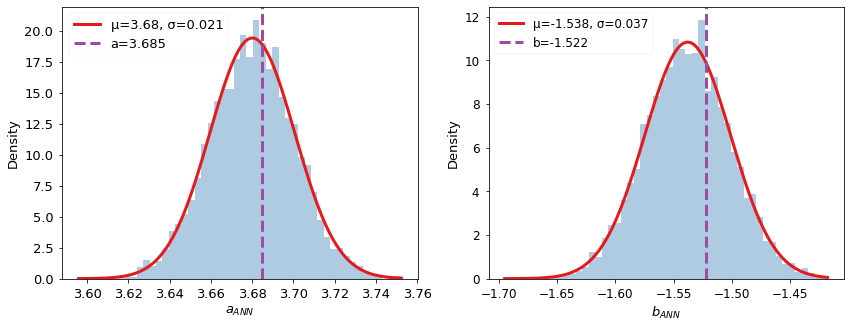

In [ ]:
import scipy
from scipy import stats

fig, axs = plt.subplots(1, 2, figsize=(14,5))

_, bins_a, _ = axs[0].hist(a_qual, 50, density = True, alpha=0.4, color = '#377eb8')
sigma_a = np.std(a_qual)
mu_a = np.mean(a_qual)
a_x_axis_gauss = np.linspace(bins_a[0], bins_a[-1], 100)
best_fit_line_a = scipy.stats.norm.pdf(a_x_axis_gauss, mu_a, sigma_a)
axs[0].plot(a_x_axis_gauss, best_fit_line_a, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_a, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_a, 3))), linewidth = 3.0)
axs[0].axvline(a_fit_DNN, linestyle="--", color = '#984ea3', linewidth = 3.0, 
            label = 'a=' + str(np.round(a_fit_DNN, 3)))
axs[0].legend(fontsize = 13)
axs[0].set_xlabel('$a_{ANN}$', fontsize = 13)
axs[0].set_ylabel('Density', fontsize = 13)
axs[0].tick_params(labelsize = 13)

_, bins_b, _ = axs[1].hist(b_qual, 50, density=True, alpha=0.4, color = '#377eb8')
sigma_b = np.std(b_qual)
mu_b = np.mean(b_qual)
b_x_axis_gauss = np.linspace(bins_b[0], bins_b[-1], 100)
best_fit_line_b = scipy.stats.norm.pdf(b_x_axis_gauss, mu_b, sigma_b)
axs[1].plot(b_x_axis_gauss, best_fit_line_b, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_b, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_b, 3))), linewidth = 3.0)
axs[1].axvline(b_fit_DNN, linestyle="--", 
            color = '#984ea3', linewidth = 3.0, label = 'b=' + str(np.round(b_fit_DNN, 3)))
axs[1].legend(fontsize = 12)
axs[1].set_xlabel('$b_{ANN}$', fontsize = 13)
axs[1].set_ylabel('Density', fontsize = 13)
axs[1].tick_params(labelsize=12)

plt.show()

##Calculate parameter variances (Bootstrap Method) 

In [ ]:
from operator import itemgetter

def var():
  data = np.zeros((N_test, 4))
  for i in range(N_test):
    index = np.random.randint(0, N_test)
    data[i,0] = X[index]
    data[i,1] = Y[index]
    data[i,2] = sigma_X[index]
    data[i,3] = sigma_Y[index]
  data = sorted(data, key=itemgetter(0)) 
  return(data)

num_of_bootstrap = 5000
set_of_sets = np.zeros((num_of_bootstrap, N_test, 4))

for i in range(num_of_bootstrap):
  set_of_sets[i] = var()

tf.convert_to_tensor(set_of_sets)

preds = model.predict(set_of_sets)

a_values = []
b_values = []
for i in range(num_of_bootstrap):
  a_values.append(preds[i,0])
  b_values.append(preds[i,1])

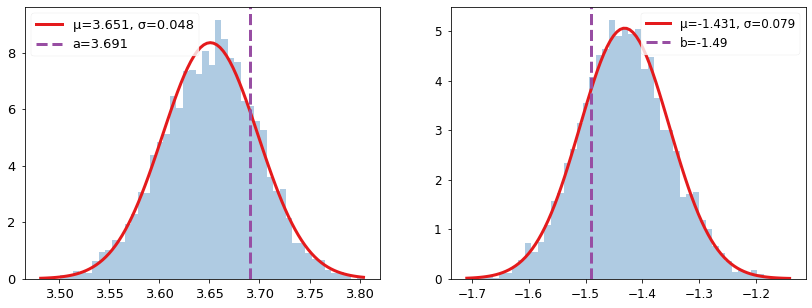

In [ ]:
import scipy
from scipy import stats

fig, axs = plt.subplots(1, 2, figsize=(14,5))

_, bins_a, _ = axs[0].hist(a_values, 50, density = True, alpha=0.4, color = '#377eb8')
sigma_a = np.std(a_values)
mu_a = np.mean(a_values)
a_x_axis_gauss = np.linspace(bins_a[0], bins_a[-1], 100)
best_fit_line_a = scipy.stats.norm.pdf(a_x_axis_gauss, mu_a, sigma_a)
axs[0].plot(a_x_axis_gauss, best_fit_line_a, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_a, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_a, 3))), linewidth = 3.0)
axs[0].axvline(a_fit_DNN, linestyle="--", color = '#984ea3', linewidth = 3.0, 
            label = 'a=' + str(np.round(a_fit_DNN, 3)))
axs[0].legend(fontsize = 13)
axs[0].tick_params(labelsize = 13)

_, bins_b, _ = axs[1].hist(b_values, 50, density=True, alpha=0.4, color = '#377eb8')
sigma_b = np.std(b_values)
mu_b = np.mean(b_values)
b_x_axis_gauss = np.linspace(bins_b[0], bins_b[-1], 100)
best_fit_line_b = scipy.stats.norm.pdf(b_x_axis_gauss, mu_b, sigma_b)
axs[1].plot(b_x_axis_gauss, best_fit_line_b, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_b, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_b, 3))), linewidth = 3.0)
axs[1].axvline(b_fit_DNN, linestyle="--", 
            color = '#984ea3', linewidth = 3.0, label = 'b=' + str(np.round(b_fit_DNN, 3)))
axs[1].legend(fontsize = 12)
axs[1].tick_params(labelsize=12)

plt.show()

# Find the $a_{ANN}-a_{true}$, $b_{ANN}-b_{true}$ distributions
We create random models then we sample data sets from them. After that, we use ANN to make predictions on each of data sets. We plot distributions of the difference between prediction and actual parameter values below.

In [ ]:
J = 50000 # number of training models

# Create random a and b pairs
a_test = np.linspace(-5.0, 5.0, J)
b_test = np.linspace(-5.0, 5.0, J)

# Shuffling the arrays to get random a and b pairs
np.random.shuffle(a_test)
np.random.shuffle(b_test)

def data_set(N, a, b):
  sigma_x = np.random.uniform(0.03, 0.07, N) # sample x coordinate sigmas from uniform distribution
  sigma_y = np.random.uniform(0.05, 0.10, N) # sample y coordinate sigmas from uniform distribution
  noise_x = np.multiply(sigma_x, np.random.randn(N)) # error on x data (normally distributed)
  noise_y = np.multiply(sigma_y, np.random.randn(N)) # error on y data (normally distributed) 
  x = np.linspace(0.1, 0.9, N) + noise_x
  y = a + b * (x-noise_x) + noise_y
  test_features = np.zeros((N, 4))
  for i in range(N):
    for k in range(1):
      test_features[i,k] = x[i]
      test_features[i,k+1] = y[i]
      test_features[i,k+2] = sigma_x[i]
      test_features[i,k+3] = sigma_y[i]
  return(test_features)

In [ ]:
test_data = []
test_labels = np.zeros((J,2))

for j in range(J):
  N = np.random.randint(10,100)
  test_data.append(data_set(N, a_test[j], b_test[j]))
  test_labels[j,0] = a_test[j]
  test_labels[j,1] = b_test[j]

test_data = tf.ragged.constant(test_data)

In [ ]:
a_diff = []
b_diff = []

preds = model.predict(test_data)
diffs = np.subtract(preds, test_labels)

for j in range(J):
  a_diff.append(diffs[j,0])
  b_diff.append(diffs[j,1])

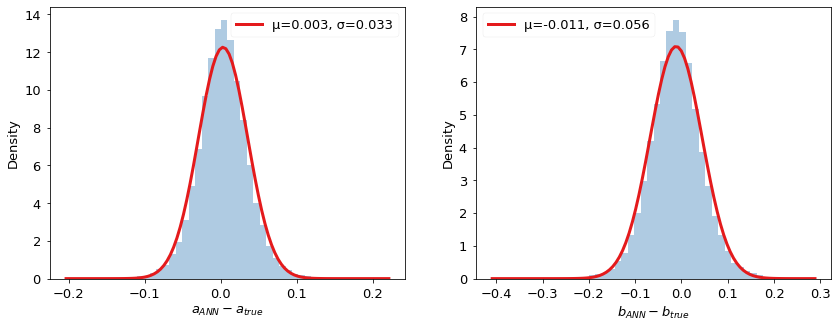

In [ ]:
import scipy
from scipy import stats

fig, axs = plt.subplots(1, 2, figsize=(14,5))

_, bins_a, _ = axs[0].hist(a_diff, 50, density = True, alpha=0.4, color = '#377eb8')
sigma_a = np.std(a_diff)
mu_a = np.mean(a_diff)
a_x_axis_gauss = np.linspace(bins_a[0], bins_a[-1], 100)
best_fit_line_a = scipy.stats.norm.pdf(a_x_axis_gauss, mu_a, sigma_a)
axs[0].plot(a_x_axis_gauss, best_fit_line_a, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_a, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_a, 3))), linewidth = 3.0)
axs[0].legend(fontsize = 13)
axs[0].set_xlabel('$a_{ANN}-a_{true}$', fontsize = 13)
axs[0].set_ylabel('Density', fontsize = 13)
axs[0].tick_params(labelsize = 13)

_, bins_b, _ = axs[1].hist(b_diff, 50, density=True, alpha=0.4, color = '#377eb8')
sigma_b = np.std(b_diff)
mu_b = np.mean(b_diff)
b_x_axis_gauss = np.linspace(bins_b[0], bins_b[-1], 100)
best_fit_line_b = scipy.stats.norm.pdf(b_x_axis_gauss, mu_b, sigma_b)
axs[1].plot(b_x_axis_gauss, best_fit_line_b, color = '#e41a1c', label = 
         ('\u03BC=' + str(np.round(mu_b, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_b, 3))), linewidth = 3.0)
axs[1].legend(fontsize = 13)
axs[1].set_xlabel('$b_{ANN}-b_{true}$', fontsize = 13)
axs[1].set_ylabel('Density', fontsize = 13)
axs[1].tick_params(labelsize=13)

plt.show()